# NN4

## Rozwiązywanie zadania klasyfikacji

Zaimplementować funkcję softmax dla warstwy wyjściowej sieci neuronowej. Sprawdzić szybkość i skuteczność w wariancie, gdy sieć używa funkcji softmax na ostatniej warstwie i gdy jest użyta zwykła funkcja aktywacji. Softmax wymaga też odpowiednich zmian w algorytmie uczenia, uwzględniających pochodną fukcji.

Przeprowadzić eksperymenty na zbiorach (w nawiasach wymagana wartość F-measure na 2 punkty):

- rings3-regular (F-measure: 0.75),
- easy (F-measure: 0.99),
- xor3 (F-measure: 0.97).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def linear(x):
    return x

def sigmoid_der(x):
    return x * (1 - x)

def linear_der(x):
    return np.ones((len(x), 1))

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def softmax_der(x):
    s = softmax(x)
    return s * (1 - s)

def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    
    one_hot[np.arange(y.shape[0]), y.flatten()] = 1
    
    return one_hot

class MLP:
    def __init__(self, layer_sizes,
                 hidden_activation='sigmoid',
                 output_activation='linear', metric = 'mse'):
        self.activation_functions = {
            'sigmoid': sigmoid,
            'linear': linear,
            'softmax': softmax
        }

        self.activation_functions_der = {
            'sigmoid': sigmoid_der,
            'linear': linear_der,
            'softmax': softmax_der
        }

        self.metrics = {
            'mse': self.mse,
            'cross-entropy': self.cross_entropy,
        }

        # output_activation = "sigmoid" - tylko dla danych [0,1]
        self.metric = self.metrics[metric]
        if metric == "mse":
            self.measure = 0
        else:
            self.measure = 1
        self.hidden_activation = self.activation_functions[hidden_activation]
        self.output_activation = self.activation_functions[output_activation]
        self.loss = []
        self.output_activation_der = self.activation_functions_der[output_activation]
        self.hidden_activation_der = self.activation_functions_der[hidden_activation]
        self.weights_history = []
        self.biases_history = []
        self.layer_sizes = layer_sizes
        self.errors = []
        self.gradients = []
        np.random.seed(42)
        self.momentum = 0
        self.weights = []
        self.biases = []
        self.epsilon = 1e-8
        self.moment_weights = []
        self.moment_biases = [] 

        # Inicjalizacja wag z normalizacją (Xavier)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) / np.sqrt(layer_sizes[i])
            b = np.zeros((layer_sizes[i + 1],))
            self.weights.append(w)
            self.biases.append(b)

            self.moment_weights.append(np.zeros_like(w))
            self.moment_biases.append(np.zeros_like(b))


    def forward(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)

        activation = X
        activations = [X]
        for i in range(len(self.weights) - 1):
            weights = self.weights[i]
            biases = self.biases[i]
            Y = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation(Y)
            activations.append(activation)

        Y = activation @ self.weights[-1] + self.biases[-1]
        activation = self.output_activation(Y)
        activations.append(activation)
        return activations

    def predict(self, X, norm):
        if norm == 0:
            return self.forward(X)[-1]
        else:
            X = (X - self.minX) / (self.maxX - self.minX)
            y_norm  = self.forward(X)[-1]
            return y_norm * (self.max - self.min) + self.min

    def set_weights_and_biases(self, layer_idx, W, b):
        self.weights[layer_idx] = W
        self.biases[layer_idx] = b

    def cross_entropy(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        cross_entropy_loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        
        return cross_entropy_loss


    def mse(self, y_true, y_pred):
        diff = y_true - y_pred
        diff = np.clip(diff, -1e150, 1e150)  
        return np.mean((diff) ** 2)
    

    def f1_score(self, y_true, y_pred):
        
        TP = np.sum(y_true * y_pred, axis=0)
        FP = np.sum((1 - y_true) * y_pred, axis=0)
        FN = np.sum(y_true * (1 - y_pred), axis=0)
        
        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        
        return np.mean(f1)
        
    def convert_to_class_indices(self, y_pred):
        return np.argmax(y_pred, axis=1)    
    
    def softmax_to_one_hot(self, y_pred):

        y_pred_one_hot = np.zeros_like(y_pred) 
        
        class_predictions = np.argmax(y_pred, axis=1) 
        
        y_pred_one_hot[np.arange(y_pred.shape[0]), class_predictions] = 1
        
        return y_pred_one_hot

    def backpropagate(self, X, y_true, activations):
        output = activations[-1] 
        error = output - y_true 
        self.errors.append(np.mean(np.square(error)))

        delta = error * self.output_activation_der(output)
        deltas = [delta]

        for i in range(len(self.weights) - 2, -1, -1):
            delta = deltas[-1] @ self.weights[i + 1].T * self.hidden_activation_der(activations[i + 1])
            deltas.append(delta)

        deltas.reverse()
        return deltas


    def update_weights_and_biases(self, activations, deltas, learning_rate):
        for i in range(len(self.weights)):
            activation = activations[i]
            delta = deltas[i]
            self.weights[i] -= learning_rate * activation.T @ delta
            self.biases[i] -= learning_rate * np.sum(delta, axis=0)


    def update_weights_and_biases_momentum(self, activations, deltas, learning_rate):
        for i in range(len(self.weights)):
            activation = activations[i]
            delta = deltas[i]

            gradient_w = activation.T @ delta
            gradient_b = np.sum(delta, axis=0)

            self.moment_weights[i] = self.momentum * self.moment_weights[i] - learning_rate * gradient_w
            self.moment_biases[i] = self.momentum * self.moment_biases[i] - learning_rate * gradient_b
            self.weights[i] += self.moment_weights[i]
            self.biases[i] += self.moment_biases[i]


    def update_weights_and_biases_RMS(self, activations, deltas, learning_rate):
        for i in range(len(self.weights)):
            activation = activations[i]
            delta = deltas[i]

            gradient_w = activation.T @ delta
            gradient_b = np.sum(delta, axis=0)

            self.moment_weights[i] = (1 - self.momentum) * (gradient_w ** 2) + self.momentum * self.moment_weights[i]
            self.moment_biases[i] = (1 - self.momentum) * (gradient_b ** 2) + self.momentum * self.moment_biases[i]

            self.weights[i] -= learning_rate * gradient_w / (np.sqrt(self.moment_weights[i]) + self.epsilon)
            self.biases[i] -= learning_rate * gradient_b / (np.sqrt(self.moment_biases[i]) + self.epsilon)


    def fit(self, X, y, epochs=1000, learning_rate=0.01, er=3, momentum=0, RMS =0, X_test=None, y_test=None, norm = 0):
        self.momentum = momentum
        m = X.shape[0]
        if norm == 1:
            self.min = min(y)
            self.max = max(y)
            self.minX = min(X)
            self.maxX = max(X)
            X = (X - self.minX) / (self.maxX - self.minX)
            y_norm = (y - self.min) / (self.max - self.min)
        else:
            y_norm = y
        for epoch in range(epochs):
            activations = self.forward(X)
            y_pred = self.predict(X, norm)
            error = self.metric(y, y_pred)
            self.errors.append(error)
            if self.measure == 0:
                loss = self.mse(y, y_pred)
                if loss < er:
                    print("finished_early on epoch: ", epoch, ", with loss = ", loss)
                    plt.plot(self.loss)
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.title('Training Loss')
                    plt.show()
                    return
            else:
                loss = self.f1_score(y, self.softmax_to_one_hot(y_pred))
                if loss > er:
                    print("finished_early on epoch: ", epoch, ", with f-measure = ", loss)
                    plt.plot(self.loss)
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.title('Training Loss')
                    plt.show()
                    return
            self.loss.append(loss)
            
            deltas = self.backpropagate(X, y_norm, activations)
            if RMS == 1:
                self.update_weights_and_biases_RMS(activations, deltas, learning_rate)
            elif RMS == 0 and self.momentum == 0:
                self.update_weights_and_biases(activations, deltas, learning_rate)
            else:
                self.update_weights_and_biases_momentum(activations, deltas, learning_rate)
            self.weights_history.append([w.copy() for w in self.weights])
            self.biases_history.append([w.copy() for w in self.biases])

            if (epoch) % 1000 == 0:
                if X_test is not None and y_test is not None:
                    if self.measure == 0:
                        test_loss = self.mse(y_test, self.predict(X_test, norm))
                    else:
                        test_loss = self.f1_score(y_test, self.predict(X_test, self.softmax_to_one_hot(norm)))
                    # test_loss = metric(y_test, self.predict(X_test, norm))
                    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss}, Test Loss: {test_loss}')
                else:
                    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss}, Error: {error}')
        plt.plot(self.loss)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()
        plt.plot(self.errors)
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.title('Training Errors')
        plt.show()


    def visualize_weights(self, layer_idx):

        if not self.weights_history:
            print("Brak danych o wagach. Uruchom najpierw metodę fit().")
            return

        weights_for_layer = np.array([weights[layer_idx] for weights in self.weights_history])

        plt.figure(figsize=(12, 6))
        for i in range(weights_for_layer.shape[1]):
            for j in range(weights_for_layer.shape[2]):
                plt.plot(weights_for_layer[:, i, j], label=f'Neuron {i}-{j}')

        plt.xlabel("Epoch")
        plt.ylabel("Weight Value")
        plt.title(f"Weight Changes for Layer {layer_idx} Over Epochs")
        plt.legend(loc='upper right', fontsize=8)
        plt.tight_layout()
        plt.show()

    def visualize_biases(self, layer_idx):
        if not self.weights_history:
            print("Brak danych o biasach. Uruchom najpierw metodę fit().")
            return

        biases_for_layer = np.array([bias[layer_idx] for bias in self.biases_history])

        if biases_for_layer.ndim == 1:
            plt.plot(biases_for_layer, label=f"Bias w warstwie {layer_idx}", color='red')
        else:
            plt.figure(figsize=(12, 6))
            for i in range(biases_for_layer.shape[1]):
                plt.plot(biases_for_layer[:, i], label=f'Bias {i} w warstwie {layer_idx}')

        plt.xlabel("Epoki")
        plt.ylabel("Wartość biasu")
        plt.title(f"Wartości biasów dla warstwy {layer_idx} w trakcie treningu")
        plt.legend()
        plt.tight_layout()
        plt.show()


    def fit_batch(self, X, y, epochs=1000, learning_rate=0.01, MSE = 3, momentum=0, RMS = 0,X_test=None, y_test=None, norm = 0, batch_size=32):
        m = X.shape[0]
        self.momentum = momentum
        if norm == 1:
            self.min = min(y)
            self.max = max(y)
            self.minX = min(X)
            self.maxX = max(X)
            X = (X - self.minX) / (self.maxX - self.minX)
            y_norm = (y - self.min) / (self.max - self.min)
        else:
            y_norm = y
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            for start_idx in range(0, m, batch_size):
                end_idx = min(start_idx + batch_size, m)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                activations = self.forward(X_batch)
                deltas = self.backpropagate(X_batch, y_batch, activations)
                if RMS == 1:
                    self.update_weights_and_biases_RMS(activations, deltas, learning_rate)
                elif RMS == 0 and self.momentum == 0:
                    self.update_weights_and_biases(activations, deltas, learning_rate)
                else:
                    self.update_weights_and_biases_momentum(activations, deltas, learning_rate)
            y_pred = self.predict(X, norm)
            error = self.metric(y, y_pred)
            self.errors.append(error)
            if self.measure == 0:
                loss = self.mse(y, y_pred)
                if loss < er:
                    print("finished_early on epoch: ", epoch, ", with loss = ", loss)
                    plt.plot(self.loss)
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.title('Training Loss')
                    plt.show()
                    return
            else:
                loss = self.f1_score(y, self.softmax_to_one_hot(y_pred))
                if loss > er:
                    print("finished_early on epoch: ", epoch, ", with f-measure = ", loss)
                    plt.plot(self.loss)
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.title('Training Loss')
                    plt.show()
                    return
            self.loss.append(loss)
            
            self.weights_history.append([w.copy() for w in self.weights])
            self.biases_history.append([b.copy() for b in self.biases])
            if (epoch) % 1000 == 0:
                if X_test is not None and y_test is not None:
                    if self.measure == 0:
                        test_loss = self.mse(y_test, self.predict(X_test, norm))
                    else:
                        test_loss = self.f1_score(y_test, self.predict(X_test, self.softmax_to_one_hot(norm)))
                    # test_loss = metric(y_test, self.predict(X_test, norm))
                    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss}, Test Loss: {test_loss}')
                else:
                    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss}, Error: {error}')
        plt.plot(self.loss)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()
        plt.plot(self.errors)
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.title('Training Errors')
        plt.show()


## 1. Zbiór rings3-regular

#### "Zwykła" funkcja aktywacji dla warstwy wyjściowej

Epoch 1/1000000, Train Loss: 0.16666666541500003, Error: 0.7613055351372805
Epoch 1001/1000000, Train Loss: 0.4332178858348325, Error: 1.0036817178139947
Epoch 2001/1000000, Train Loss: 0.4699159292926652, Error: 0.9875672138771999
Epoch 3001/1000000, Train Loss: 0.48942409916026813, Error: 0.9616846469467666
Epoch 4001/1000000, Train Loss: 0.4729964430134566, Error: 0.9179589815662551
Epoch 5001/1000000, Train Loss: 0.4759267932163594, Error: 0.9153562722840176
Epoch 6001/1000000, Train Loss: 0.5346446629727234, Error: 0.9131928422419339
Epoch 7001/1000000, Train Loss: 0.542707447474724, Error: 0.8737607083864405
Epoch 8001/1000000, Train Loss: 0.5355971262648467, Error: 0.8865620423629892
Epoch 9001/1000000, Train Loss: 0.5713037691842926, Error: 0.8558713678874464
Epoch 10001/1000000, Train Loss: 0.5313930462264586, Error: 0.9482722692550963
Epoch 11001/1000000, Train Loss: 0.5749296008963148, Error: 0.9207769122758164
Epoch 12001/1000000, Train Loss: 0.6098432210892493, Error: 0.82

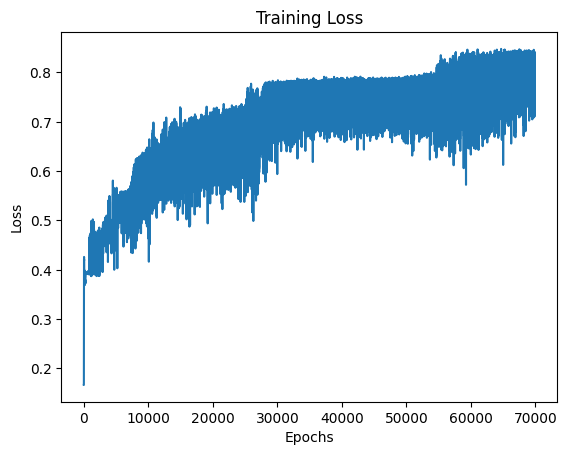

Train F-measure:  0.8507376273785666
Test F-measure:  0.7053511232806898


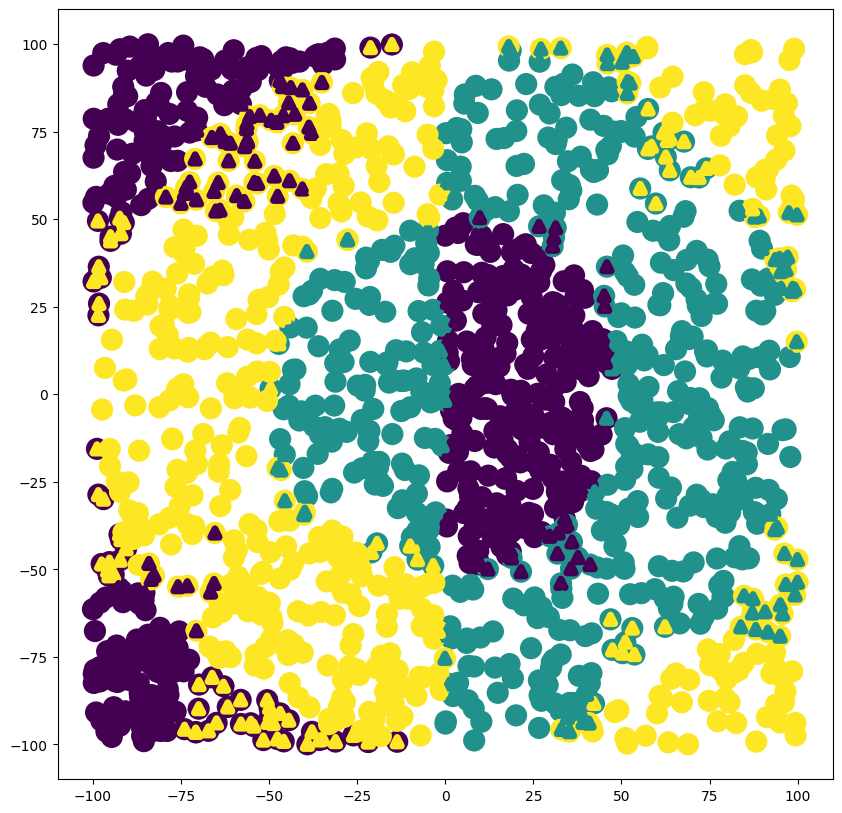

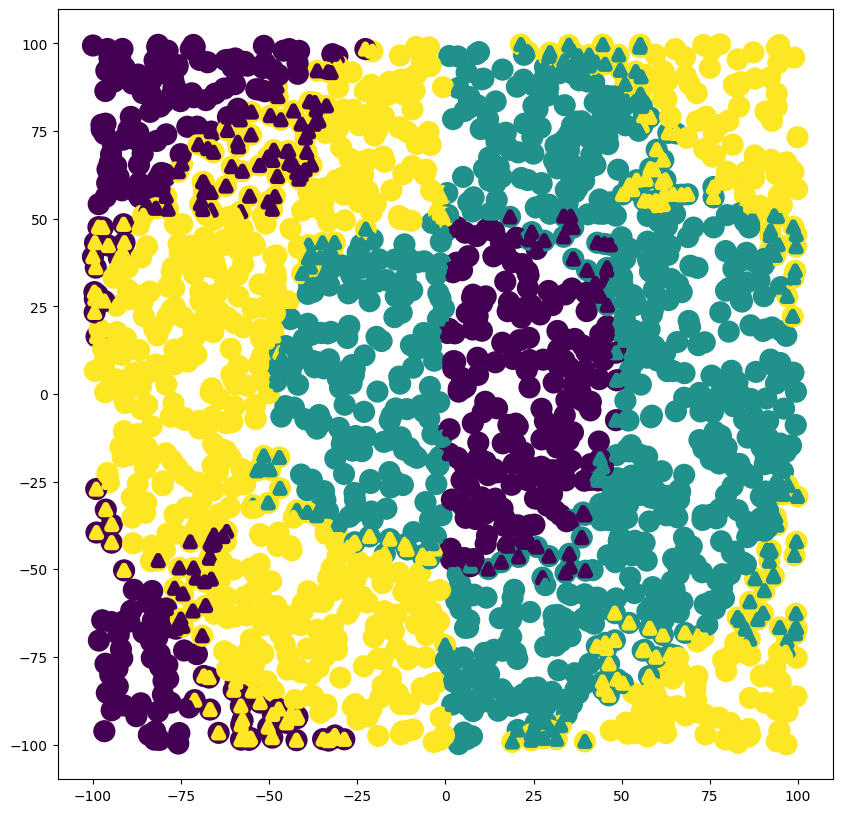

In [14]:
df = pd.read_csv('mio1/classification/rings3-regular-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true = one_hot_encode(y, 3)
mlp = MLP([2,8,6,4,3], 'sigmoid', 'sigmoid', "cross-entropy")
mlp.fit(X, y_true,1000000, 0.001, 0.85)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=2)

df = pd.read_csv('mio1/classification/rings3-regular-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true_test = one_hot_encode(y_test, 3)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_prob_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=2)


#### Softmax dla warstwy wyjściowej

Epoch 1/1000000, Train Loss: 0.16666666541500003, Error: 1.1226081952843452
Epoch 1001/1000000, Train Loss: 0.45085516083587684, Error: 1.0150339178764134
Epoch 2001/1000000, Train Loss: 0.46701527654687164, Error: 0.9601044063259897
Epoch 3001/1000000, Train Loss: 0.5264938422076866, Error: 0.9366894054448277
Epoch 4001/1000000, Train Loss: 0.526866237235702, Error: 0.9320386959086912
Epoch 5001/1000000, Train Loss: 0.5309445157956288, Error: 0.8873888866545597
Epoch 6001/1000000, Train Loss: 0.5523876082615083, Error: 0.8782132936899579
Epoch 7001/1000000, Train Loss: 0.545585958894171, Error: 0.892775992648706
Epoch 8001/1000000, Train Loss: 0.5352411302710619, Error: 0.9269354292178674
Epoch 9001/1000000, Train Loss: 0.544268290854126, Error: 0.9023239022786774
Epoch 10001/1000000, Train Loss: 0.5924812517155481, Error: 0.8223572829660862
Epoch 11001/1000000, Train Loss: 0.6523633776605801, Error: 0.7368961683044694
Epoch 12001/1000000, Train Loss: 0.6479494077227937, Error: 0.7593

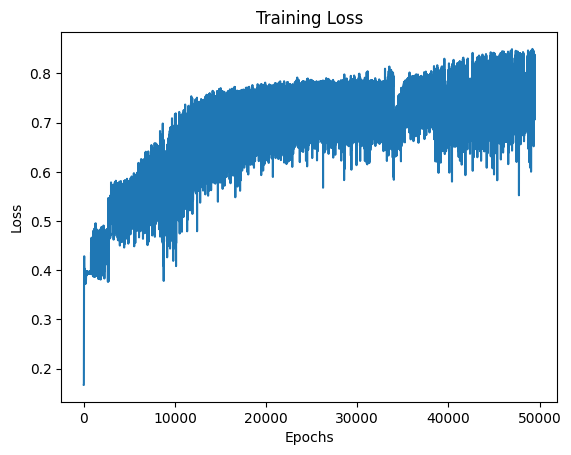

Train F-measure:  0.8537422528088631
Test F-measure:  0.7181260224466607


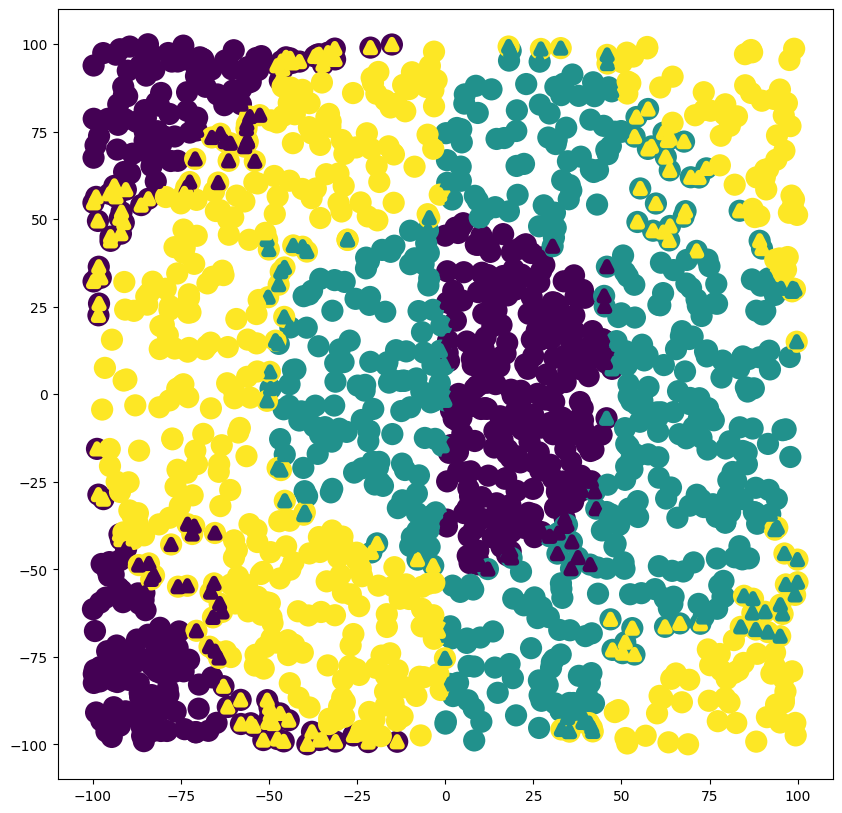

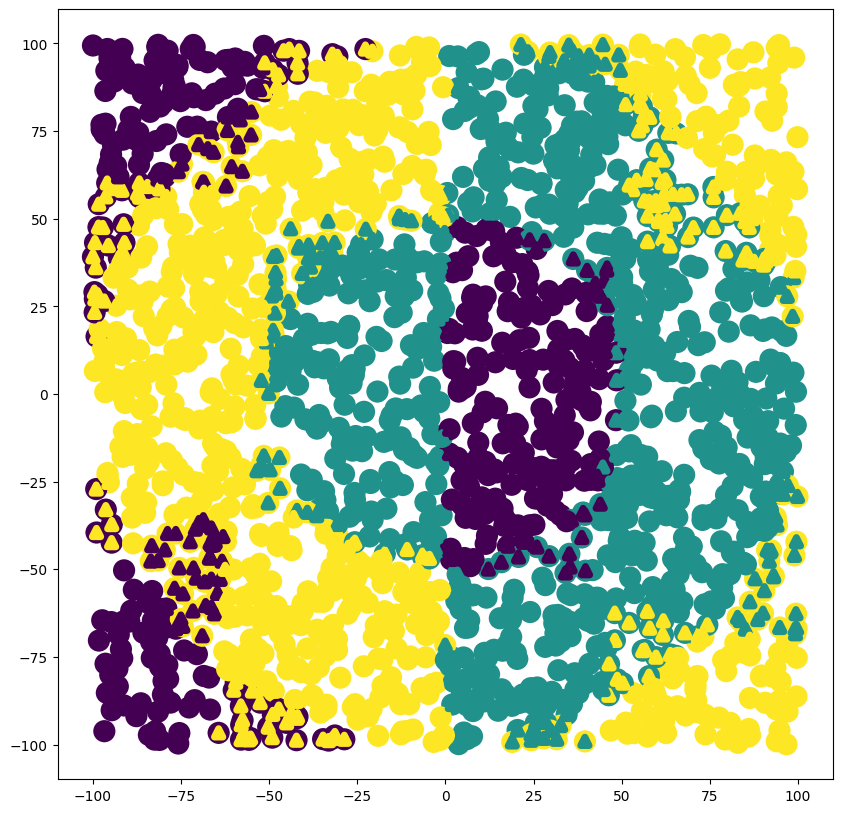

In [16]:
df = pd.read_csv('mio1/classification/rings3-regular-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true = one_hot_encode(y, 3)
mlp = MLP([2,8,6,4,3], 'sigmoid', 'softmax', "cross-entropy")
mlp.fit(X, y_true,1000000, 0.001, 0.85)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=2)

df = pd.read_csv('mio1/classification/rings3-regular-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true_test = one_hot_encode(y_test, 3)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_prob_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=2)
#24

#### Czas uczenia:
- "zwykła" funkcja aktywacji w warstwie wyjściowej: epoka 69 887, z f-measure = 0.8507376273785666
- softmax w warstwie wyjściowej: epoka 49 465, z f-measure = 0.8537422528088631

## 2. Zbiór easy

#### "Zwykła" funkcja aktywacji dla warstwy wyjściowej

Epoch 1/1000000, Train Loss: 0.871967348755364, Error: 1.0782723523607194
Epoch 1001/1000000, Train Loss: 0.99999999496, Error: 0.13162453737240132
Epoch 2001/1000000, Train Loss: 0.99999999496, Error: 0.0884336084204281
Epoch 3001/1000000, Train Loss: 0.99999999496, Error: 0.0698939870227847
Epoch 4001/1000000, Train Loss: 0.99999999496, Error: 0.058831311145233586
Epoch 5001/1000000, Train Loss: 0.99999999496, Error: 0.05154442197930358
Epoch 6001/1000000, Train Loss: 0.99999999496, Error: 0.046054579961844165
Epoch 7001/1000000, Train Loss: 0.99999999496, Error: 0.04194385413208968
Epoch 8001/1000000, Train Loss: 0.99999999496, Error: 0.038734974902753745
Epoch 9001/1000000, Train Loss: 0.99999999496, Error: 0.035956721738297094
Epoch 10001/1000000, Train Loss: 0.99999999496, Error: 0.03368979023215605
Epoch 11001/1000000, Train Loss: 0.99999999496, Error: 0.03154487774691276
Epoch 12001/1000000, Train Loss: 0.99999999496, Error: 0.029607291088667498
Epoch 13001/1000000, Train Loss:

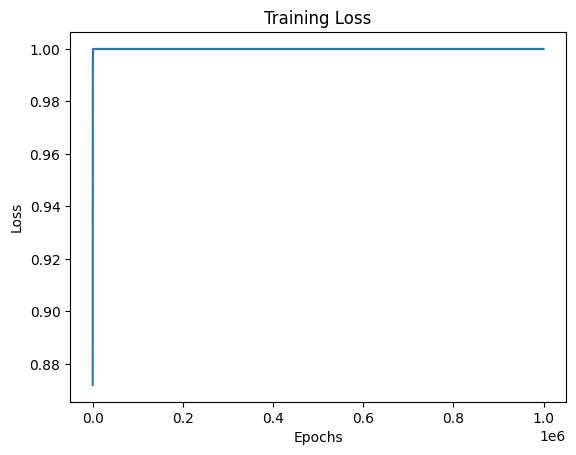

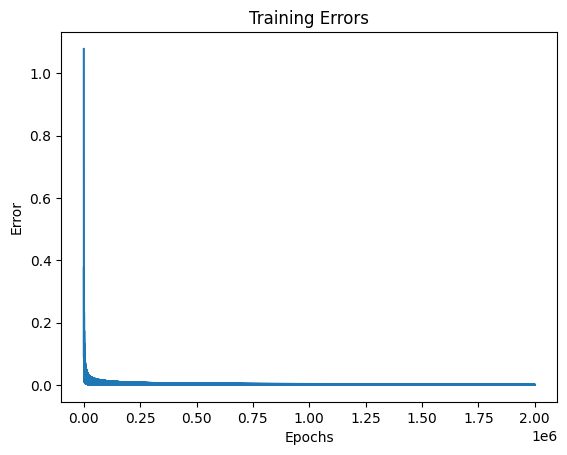

Train F-measure:  0.99999999496
Test F-measure:  0.9967374012475083


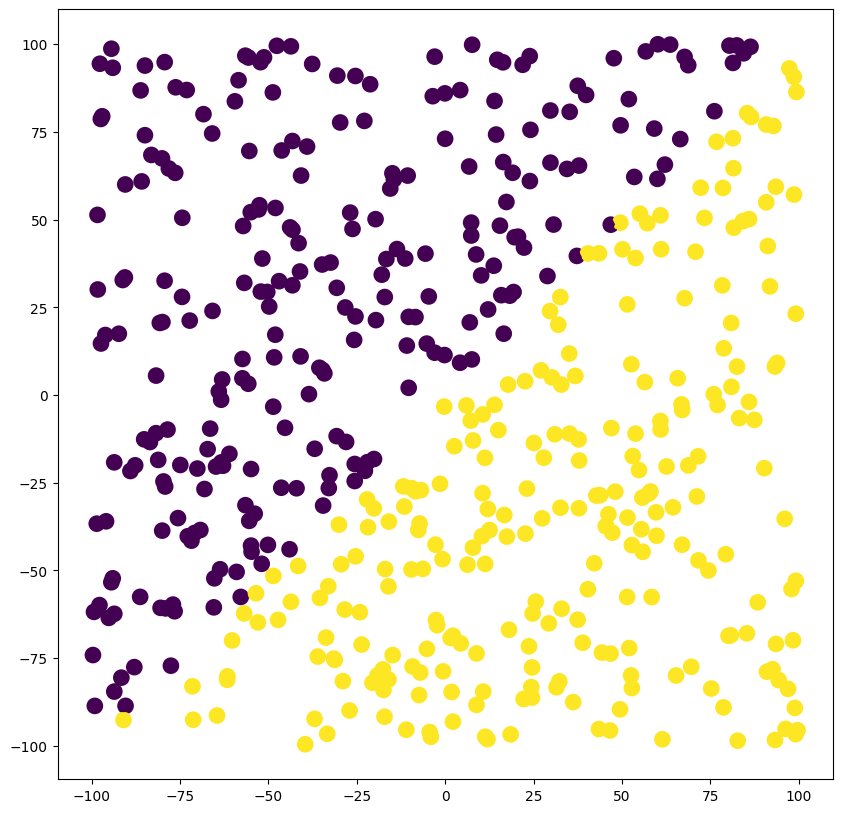

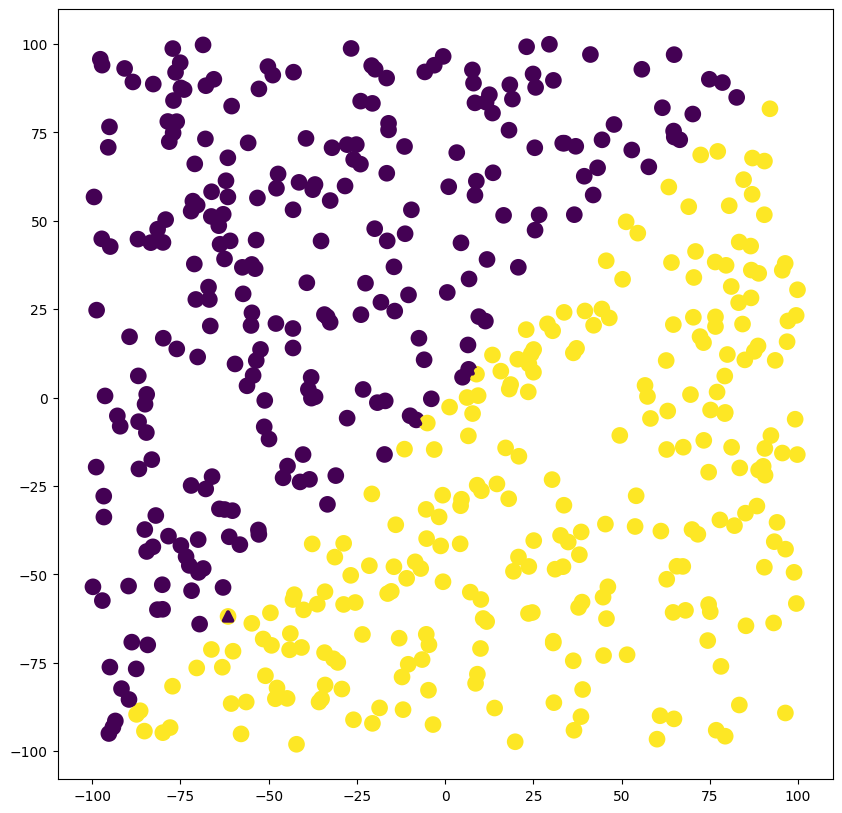

In [ ]:
df = pd.read_csv('mio1/classification/easy-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y = y.astype(int)
y_true = one_hot_encode(y, 2)
mlp = MLP([2,5,2], 'sigmoid', 'sigmoid', "cross-entropy")
mlp.fit(X, y_true,1000000, 0.0001, 0.9999999999)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred).reshape(-1,1)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=6, vmin=0, vmax=1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 3, vmin=0, vmax=1)

df = pd.read_csv('mio1/classification/easy-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_test = y_test.astype(int)

y_true_test = one_hot_encode(y_test, 2)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_prob_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=6, vmin=0, vmax=1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 3, vmin=0, vmax=1)


#### Softmax dla warstwy wyjściowej

Epoch 1/1000000, Train Loss: 0.871967348755364, Error: 0.49612587479677833
Epoch 1001/1000000, Train Loss: 0.99999999496, Error: 0.0714994196633265
Epoch 2001/1000000, Train Loss: 0.99999999496, Error: 0.028649083690842042
Epoch 3001/1000000, Train Loss: 0.99999999496, Error: 0.02076521086175041
Epoch 4001/1000000, Train Loss: 0.99999999496, Error: 0.016512955249269944
Epoch 5001/1000000, Train Loss: 0.99999999496, Error: 0.013852717938100483
Epoch 6001/1000000, Train Loss: 0.99999999496, Error: 0.012000867770954762
Epoch 7001/1000000, Train Loss: 0.99999999496, Error: 0.010626864359691495
Epoch 8001/1000000, Train Loss: 0.99999999496, Error: 0.0095615340469997
Epoch 9001/1000000, Train Loss: 0.99999999496, Error: 0.008706823132273842
Epoch 10001/1000000, Train Loss: 0.99999999496, Error: 0.008002609417231391
Epoch 11001/1000000, Train Loss: 0.99999999496, Error: 0.007412155684383407
Epoch 12001/1000000, Train Loss: 0.99999999496, Error: 0.006911435346997403
Epoch 13001/1000000, Train 

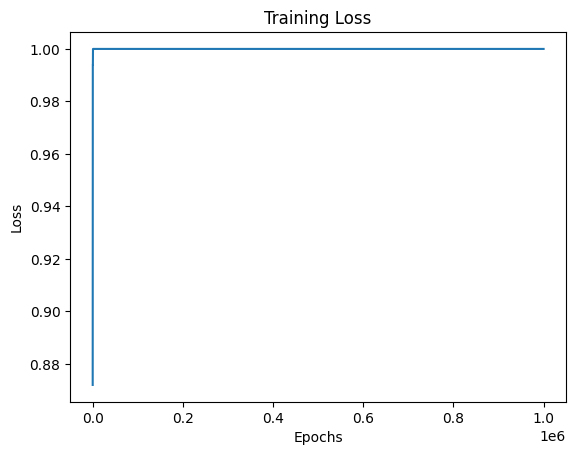

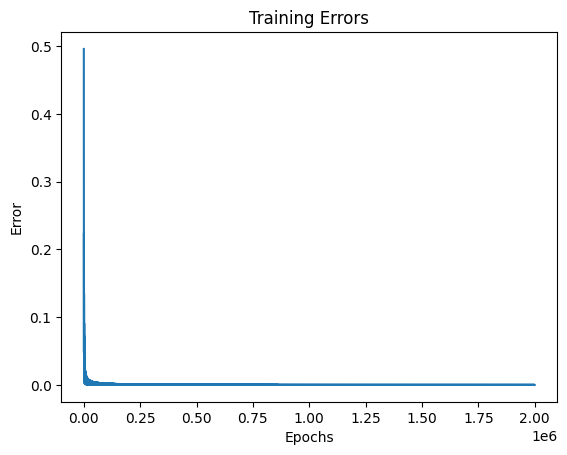

Train F-measure:  0.99999999496
Test F-measure:  0.9981804898918212


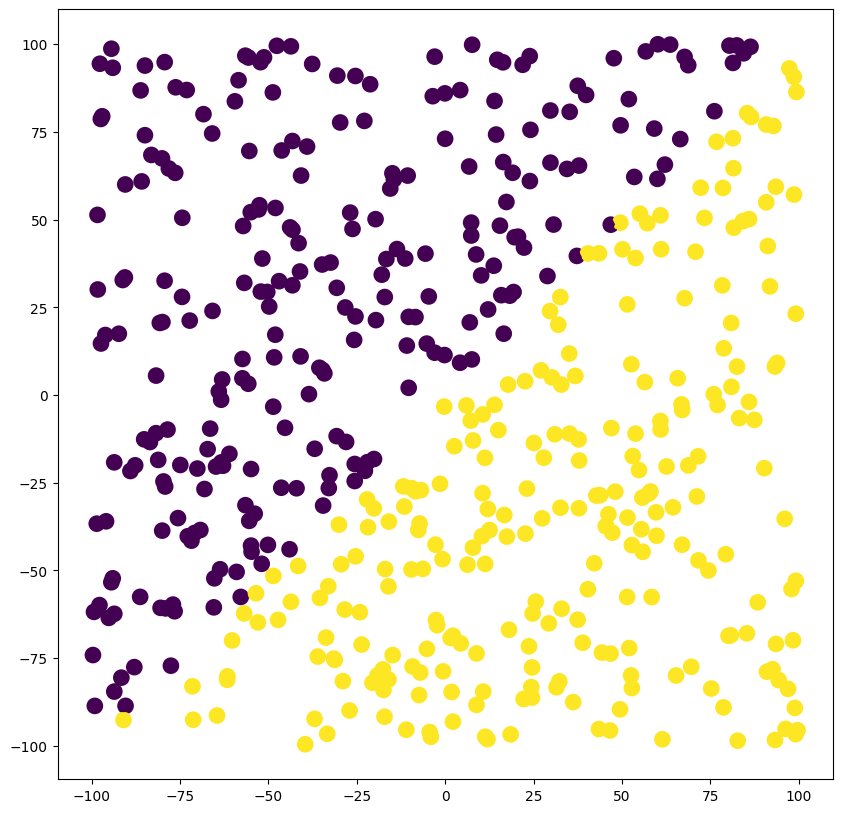

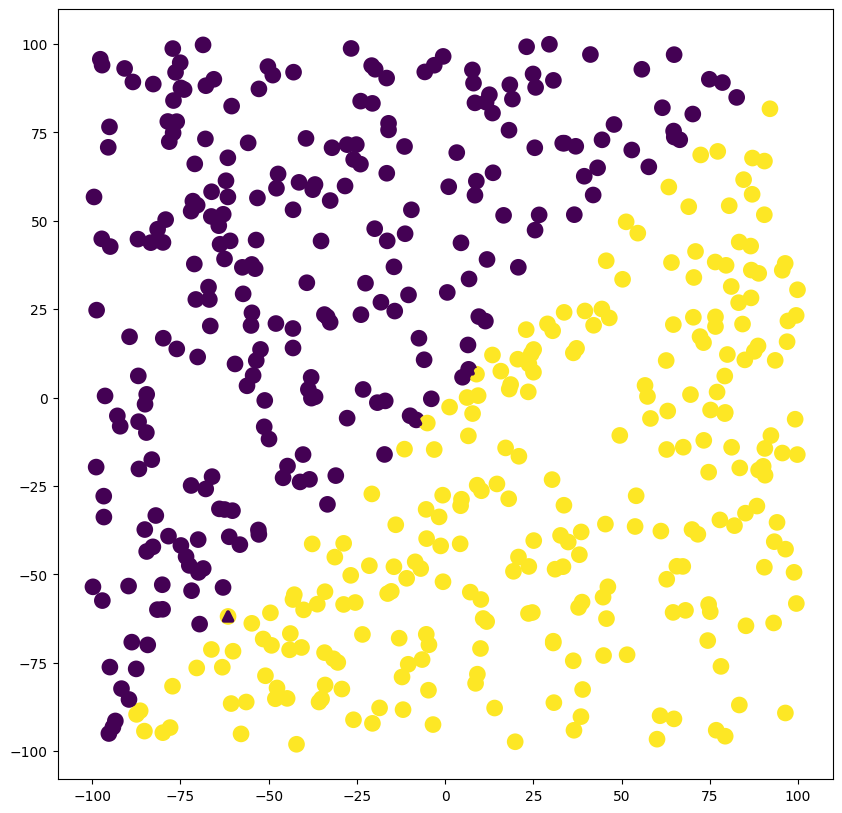

In [ ]:
df = pd.read_csv('mio1/classification/easy-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y = y.astype(int)
y_true = one_hot_encode(y, 2)
mlp = MLP([2,5,2], 'sigmoid', 'softmax', "cross-entropy")
mlp.fit(X, y_true,1000000, 0.0001, 0.9999999999)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred).reshape(-1,1)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=6, vmin=0, vmax=1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 3, vmin=0, vmax=1)

df = pd.read_csv('mio1/classification/easy-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_test = y_test.astype(int)

y_true_test = one_hot_encode(y_test, 2)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_prob_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=6, vmin=0, vmax=1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 3, vmin=0, vmax=1)


#### Czas uczenia:
- "zwykła" funkcja aktywacji w warstwie wyjściowej: epoka 1000000, z f-measure na zbiorze treningowym = 0.99999999496 oraz na zbiorze testowym = 0.9967374012475083
- softmax w warstwie wyjściowej: epoka 1000000, z f-measure na zbiorze treningowym = 0.99999999496 oraz na zbiorze testowym = 0.9981804898918212

## 3. Zbiór xor3

#### "Zwykła" funkcja aktywacji dla warstwy wyjściowej

Epoch 1/1000000, Train Loss: 0.33333333110222224, Error: 0.7107584014231372
Epoch 1001/1000000, Train Loss: 0.48589923123184986, Error: 0.693123156638448
Epoch 2001/1000000, Train Loss: 0.46419755559227016, Error: 0.69308296774953
Epoch 3001/1000000, Train Loss: 0.5359702970782154, Error: 0.6930439275313991
Epoch 4001/1000000, Train Loss: 0.5219980829714921, Error: 0.6929906702767931
Epoch 5001/1000000, Train Loss: 0.5219827863597905, Error: 0.6929104896753068
Epoch 6001/1000000, Train Loss: 0.5298476656257161, Error: 0.6927720456556173
Epoch 7001/1000000, Train Loss: 0.5376874717161497, Error: 0.6924916707785912
Epoch 8001/1000000, Train Loss: 0.5397348822763759, Error: 0.6918074888400131
Epoch 9001/1000000, Train Loss: 0.5628178544831703, Error: 0.6885251489159775
Epoch 10001/1000000, Train Loss: 0.6846017411142278, Error: 0.5912614433436263
Epoch 11001/1000000, Train Loss: 0.8899643434149104, Error: 0.3179209649001772
Epoch 12001/1000000, Train Loss: 0.8979897939444754, Error: 0.297

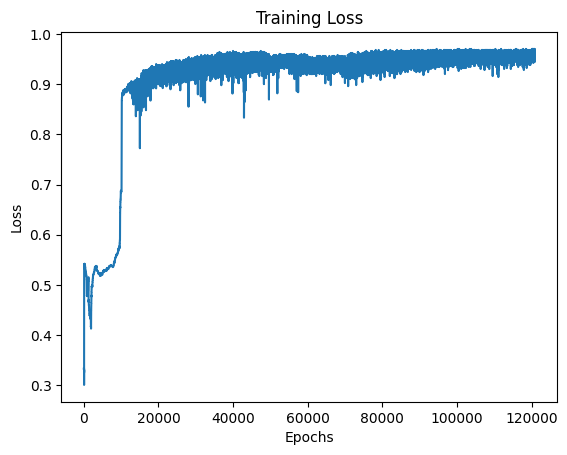

Train F-measure:  0.9719928251269138
Test F-measure:  0.8511954284778938


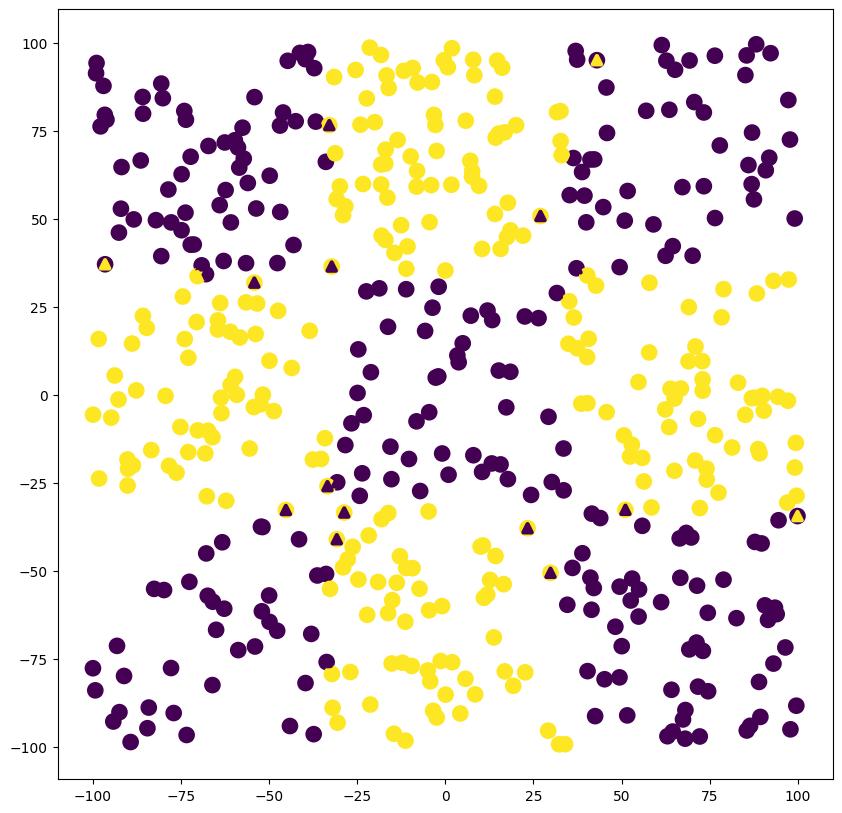

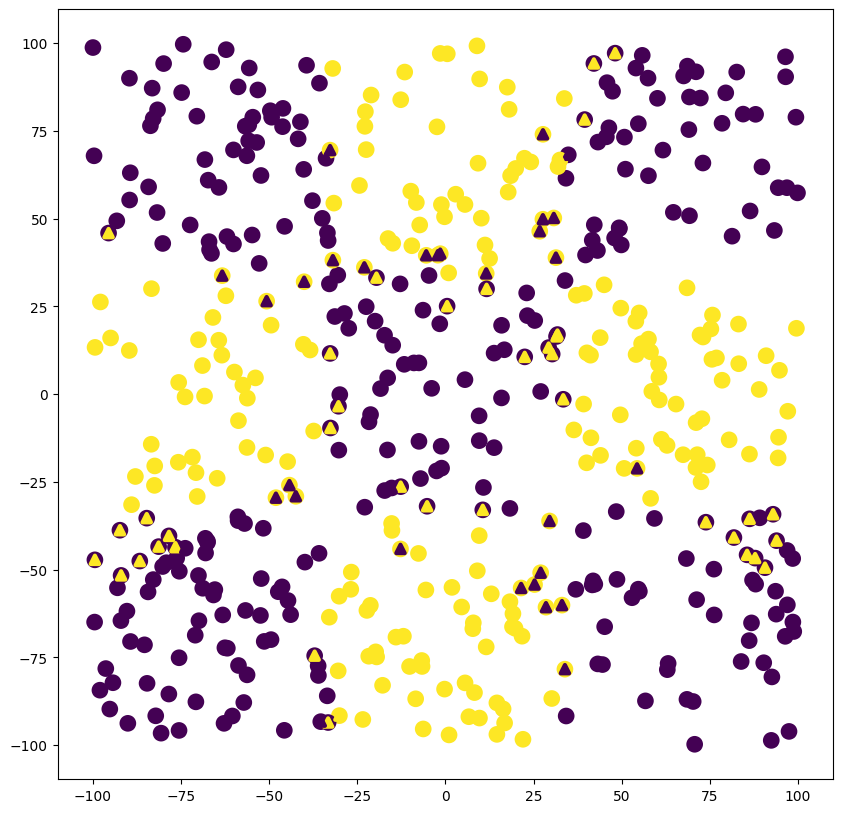

In [19]:
df = pd.read_csv('mio1/classification/xor3-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y = y.astype(int)
y_true = one_hot_encode(y, 2)
mlp = MLP([2,32,16,8,4,2], 'sigmoid', 'sigmoid', "cross-entropy")
mlp.fit(X, y_true,1000000, 0.001, 0.97)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred).reshape(-1,1)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=6, vmin=0, vmax=1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 3, vmin=0, vmax=1)

df = pd.read_csv('mio1/classification/xor3-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_test = y_test.astype(int)

y_true_test = one_hot_encode(y_test, 2)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_prob_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=6, vmin=0, vmax=1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 3, vmin=0, vmax=1)


#### Softmax dla warstwy wyjściowej

Epoch 1/1000000, Train Loss: 0.33333333110222224, Error: 0.7193576958174185
Epoch 1001/1000000, Train Loss: 0.617391299443302, Error: 0.6925964757463422
Epoch 2001/1000000, Train Loss: 0.5959595909872055, Error: 0.691071717913415
Epoch 3001/1000000, Train Loss: 0.6077740728474216, Error: 0.6837576955180753
Epoch 4001/1000000, Train Loss: 0.6495949267208951, Error: 0.634051547537897
Epoch 5001/1000000, Train Loss: 0.8779174671794645, Error: 0.3853553595031069
Epoch 6001/1000000, Train Loss: 0.8799999949648, Error: 0.3152101793634423
Epoch 7001/1000000, Train Loss: 0.865909349692524, Error: 0.3328974580641567
Epoch 8001/1000000, Train Loss: 0.8939893939046315, Error: 0.29282283620450933
Epoch 9001/1000000, Train Loss: 0.8959933385384671, Error: 0.29175422690513325
Epoch 10001/1000000, Train Loss: 0.891984440725226, Error: 0.28811023029315835
Epoch 11001/1000000, Train Loss: 0.8919723398858936, Error: 0.28591882234699495
Epoch 12001/1000000, Train Loss: 0.8899643434149104, Error: 0.281927

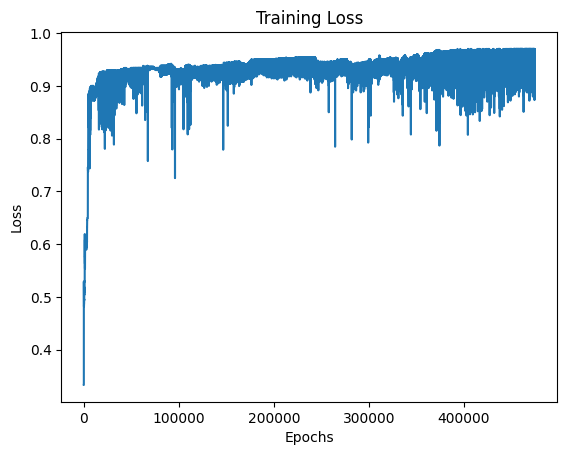

Train F-measure:  0.9719995469540312
Test F-measure:  0.8496015727494322


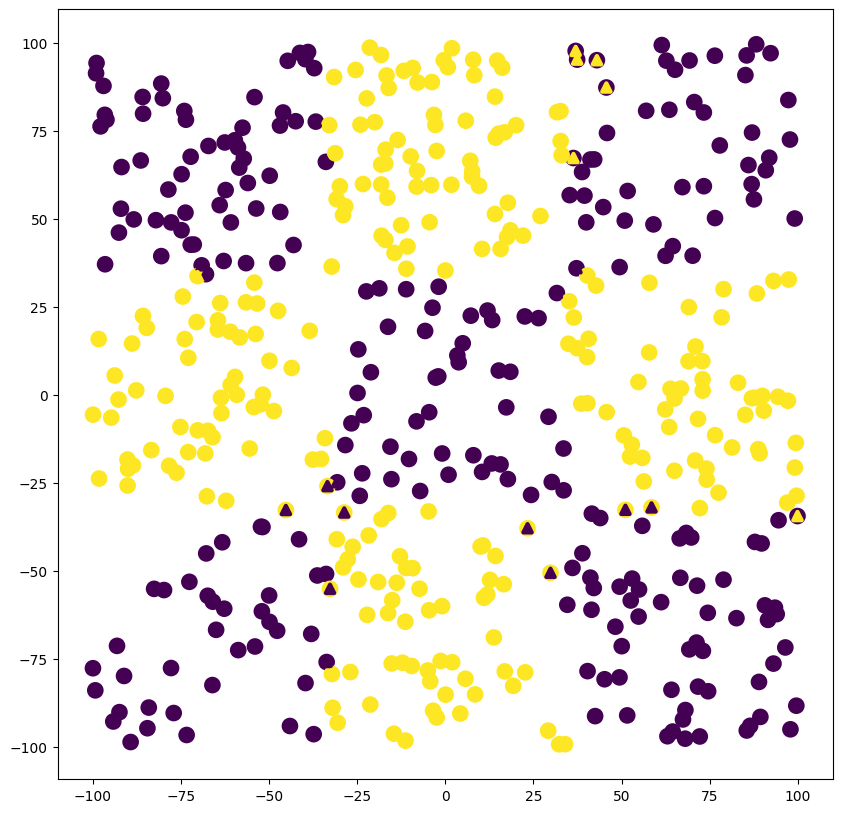

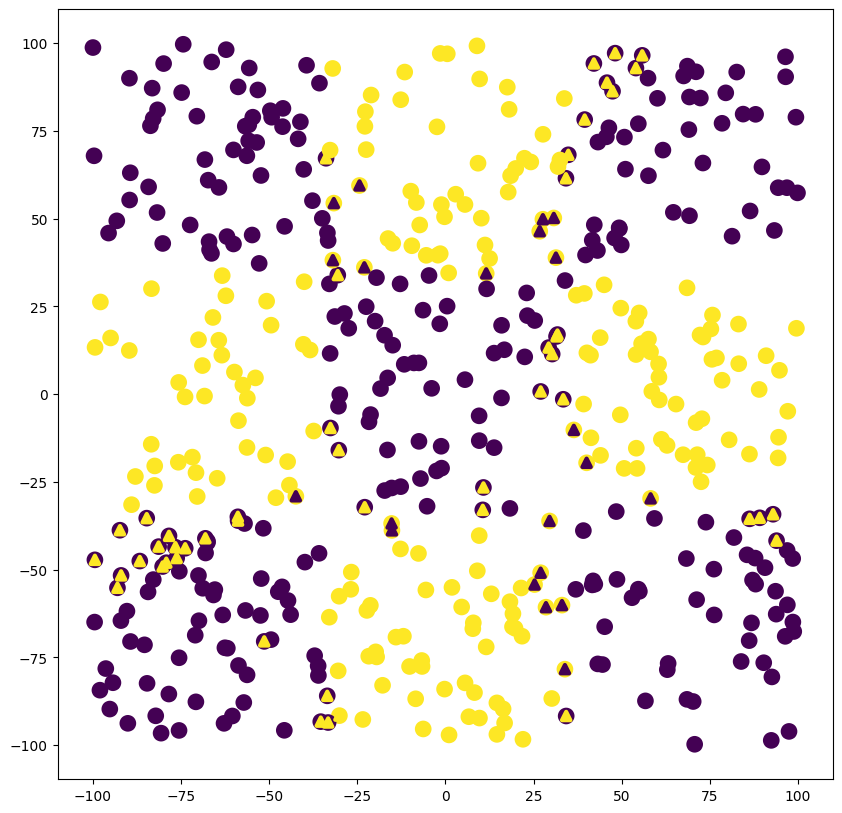

In [ ]:
df = pd.read_csv('mio1/classification/xor3-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y = y.astype(int)
y_true = one_hot_encode(y, 2)
mlp = MLP([2,16,8,4,2], 'sigmoid', 'softmax', "cross-entropy")
mlp.fit(X, y_true,1000000, 0.001, 0.97)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred).reshape(-1,1)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=6, vmin=0, vmax=1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 3, vmin=0, vmax=1)

df = pd.read_csv('mio1/classification/xor3-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_test = y_test.astype(int)

y_true_test = one_hot_encode(y_test, 2)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_prob_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=6, vmin=0, vmax=1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 3, vmin=0, vmax=1)


#### Czas uczenia:
- "zwykła" funkcja aktywacji w warstwie wyjściowej: epoka 120 819, z f-measure = 0.9719928251269138
- softmax w warstwie wyjściowej: epoka 474 415, z f-measure = 0.9719995469540312